In [22]:
from datetime import datetime, timedelta
from tqdm import tqdm

def get_past_articles(past=30):
    past_articles = {}
    for past_days in range(1, past):
        from_day = str(datetime.now() - timedelta(days=past_days))
        to_day = str(datetime.now() - timedelta(days=past_days - 1))
        past_articles.update({from_day: to_day})
    return past_articles

def get_articles(query, past=30):
    past_articles = get_past_articles(past)
    all_articles = []

    for from_day, to_day in tqdm(past_articles.items()):
        for pag in tqdm(range(1, 6)):
            pag_articles = newsapi.get_everything(q=query, language='en', from_param=from_day, to=to_day,
                                                  sort_by='relevancy', page=pag)['articles']

            if len(pag_articles) == 0:
                break

            all_articles.extend(pag_articles)

    return all_articles

In [23]:
import pandas as pd

# Load the DataFrame from the pickle file
df = pd.read_pickle('articles.pickle')


In [24]:
# Ensure columns are named correctly
df.columns = ['desc', 'date', 'title']

# Drop duplicate rows based on the 'title' column and reset the index
df = df.drop_duplicates(subset='title').reset_index(drop=True)

# Drop rows with missing values (NaN) in any column
df = df.dropna()

In [25]:
# Filter events related to Israel-Hamas conflict
israel_hamas_keywords = ['Israel', 'Hamas', 'Gaza', 'Palestine', 'IDF']
israel_hamas_events = df[df['desc'].str.contains('|'.join(israel_hamas_keywords), case=False) |
                         df['title'].str.contains('|'.join(israel_hamas_keywords), case=False)]

# Display the first few rows of the filtered DataFrame
print(israel_hamas_events.head())

                                                desc  \
0  Sanjay Raut a member of the Shiv Sena UBT part...   
1  Kozhikode Kerala India October 27 ANI Pointing...   
2  Mumbai Oct 24 PTI Maharashtra Chief Minister E...   
3  Sensex Nifty rebound over 1 pc after six sessi...   
4  October 26 2023 0815 pm Updated 0838 pm IST Ko...   

                              date  \
0 2023-10-27 13:12:18.339000+00:00   
1 2023-10-27 13:12:45.595000+00:00   
2 2023-10-27 13:12:18.339000+00:00   
3 2023-10-27 13:12:41.618000+00:00   
4 2023-10-27 13:12:45.595000+00:00   

                                               title  
0  Shiv Sena MP Sanjay Raut Responds To Hamas Rem...  
1  At IUMLs proPalestine rally in Kerala Tharoor ...  
2  Uddhav buried Bal Thackerays Hindutva for powe...  
3  New Bills replacing IPC CrPC Evidence Act will...  
4  Israel biggest terrorist nation in the world s...  


In [26]:
israel_hamas_events.shape

(31739, 3)

In [27]:
import spacy

In [28]:
# Load the SpaCy language model
nlp = spacy.load('en_core_web_lg')

In [29]:
# Initialize dictionary to store sentence vectors
sent_vecs = {}
docs = []

# Generate sentence vectors for the filtered article titles
for title in tqdm(israel_hamas_events.title):
    doc = nlp(title)
    docs.append(doc)
    sent_vecs.update({title: doc.vector})

# Extract sentences and vectors for further processing
sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

100%|████████████████████| 31739/31739 [10:46<00:00, 49.11it/s]


In [30]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min

In [31]:
# Define the helper functions
def get_mean_vector(sents):
    a = np.zeros(300)
    for sent in sents:
        a += nlp(sent).vector
    return a / len(sents)

def get_central_vector(sents):
    vecs = []
    for sent in sents:
        doc = nlp(sent)
        vecs.append(doc.vector)
    mean_vec = get_mean_vector(sents)
    index = pairwise_distances_argmin_min(np.array([mean_vec]), vecs)[0][0]
    return sents[index]

In [32]:
x = np.array(vectors)
n_classes = {}
eps_values = np.arange(0.001, 1, 0.002)
for i in tqdm(eps_values):
    dbscan = DBSCAN(eps=i, min_samples=2, metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:01:06<00:00, 72.13s/it]


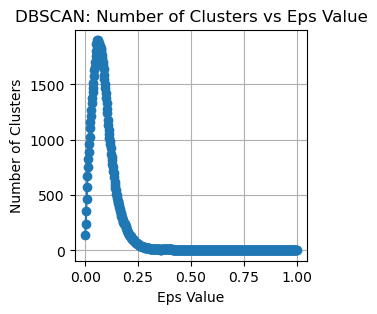

In [85]:
# Plot the number of clusters as a function of eps
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.plot(list(n_classes.keys()), list(n_classes.values()), marker='o')
plt.xlabel('Eps Value')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN: Number of Clusters vs Eps Value')
plt.grid(True)
plt.show()

In [35]:
# Choose an eps value based on the plot (e.g., 0.08 based on prior knowledge)
optimal_eps = 0.08
dbscan = DBSCAN(eps=optimal_eps, min_samples=2, metric='cosine').fit(x)

In [37]:
# Create a DataFrame with the clustering results
results = pd.DataFrame({'label': dbscan.labels_, 'sent': sentences})

In [63]:
# Extract events using the central vector for each cluster
event_sents = []
for label in set(results['label']):
    if label == -1:
        continue  # Skip noise
    cluster_sents = results[results.label == label].sent.tolist()
    central_sent = get_central_vector(cluster_sents)
    event_sents.append(central_sent)

In [64]:
israel_hamas_keywords = ['israel', 'hamas', 'gaza', 'idf', 'palestine']  # Adjust these keywords as necessary
important_phrases = ['airstrike', 'ceasefire', 'major attack', 'peace talks', 'UN resolution', 'military operation', 'significant escalation', 'diplomatic efforts']

# Generate the event DataFrame using the titles of the clustered sentences
event_df = df[df['title'].isin(event_sents)][['date', 'title']]
event_df['date'] = pd.to_datetime(event_df['date'])
event_df = event_df.sort_values(by='date').dropna()

# Filter event_df based on the keywords
event_df = event_df[event_df['title'].str.contains('|'.join(israel_hamas_keywords), case=False)]

# Filter event_df based on the important phrases
important_events_df = event_df[event_df['title'].str.contains('|'.join(important_phrases), case=False)]

# Ensure that important_events_df contains only 10 events
important_events_df = important_events_df.head(10)

# Display the final important events DataFrame
print(important_events_df)

                                 date  \
86   2023-10-27 13:16:01.883000+00:00   
188  2023-10-27 13:16:24.650000+00:00   
627  2023-10-27 13:17:56.759000+00:00   
1486 2023-10-27 13:32:02.245000+00:00   
2712 2023-12-03 06:02:56.487000+00:00   

                                                  title  
86    Gaza EU stops short of calling for ceasefire a...  
188   Release of hostages needs ceasefire Hamas offi...  
627   Hamas Battalion Leader Killed By IDF Airstrike...  
1486  Israel vows again to destroy Hamas rejecting c...  
2712  Hamas Reneged On Commitments Blinken On Why Ga...  


In [68]:
important_events_df.head(10)

,date,title
0,2023-10-27 13:16:01.883000+00:00,Gaza EU stops short of calling for ceasefire a...
1,2023-10-27 13:16:24.650000+00:00,Release of hostages needs ceasefire Hamas offi...
2,2023-10-27 13:17:56.759000+00:00,Hamas Battalion Leader Killed By IDF Airstrike...
3,2023-10-27 13:32:02.245000+00:00,Israel vows again to destroy Hamas rejecting c...
4,2023-12-03 06:02:56.487000+00:00,Hamas Reneged On Commitments Blinken On Why Ga...
5,2023-12-03 06:02:56.487000+00:00,Israel resumes Gaza military operation after c...
6,2023-12-03 14:02:02.606000+00:00,Israeli airstrike hit Damascus airport and put...
7,2023-12-03 14:03:50.874000+00:00,IsraelHamas Ceasefire Deal Will Do Everything ...
8,2023-12-03 16:05:19.517000+00:00,Iran Demands End To Israeli Crimes Calls For P...
9,2023-12-03 20:04:05.583000+00:00,war to continue till Hamas are crushed as 5 na...


In [70]:
important_events_df.shape

(79, 2)

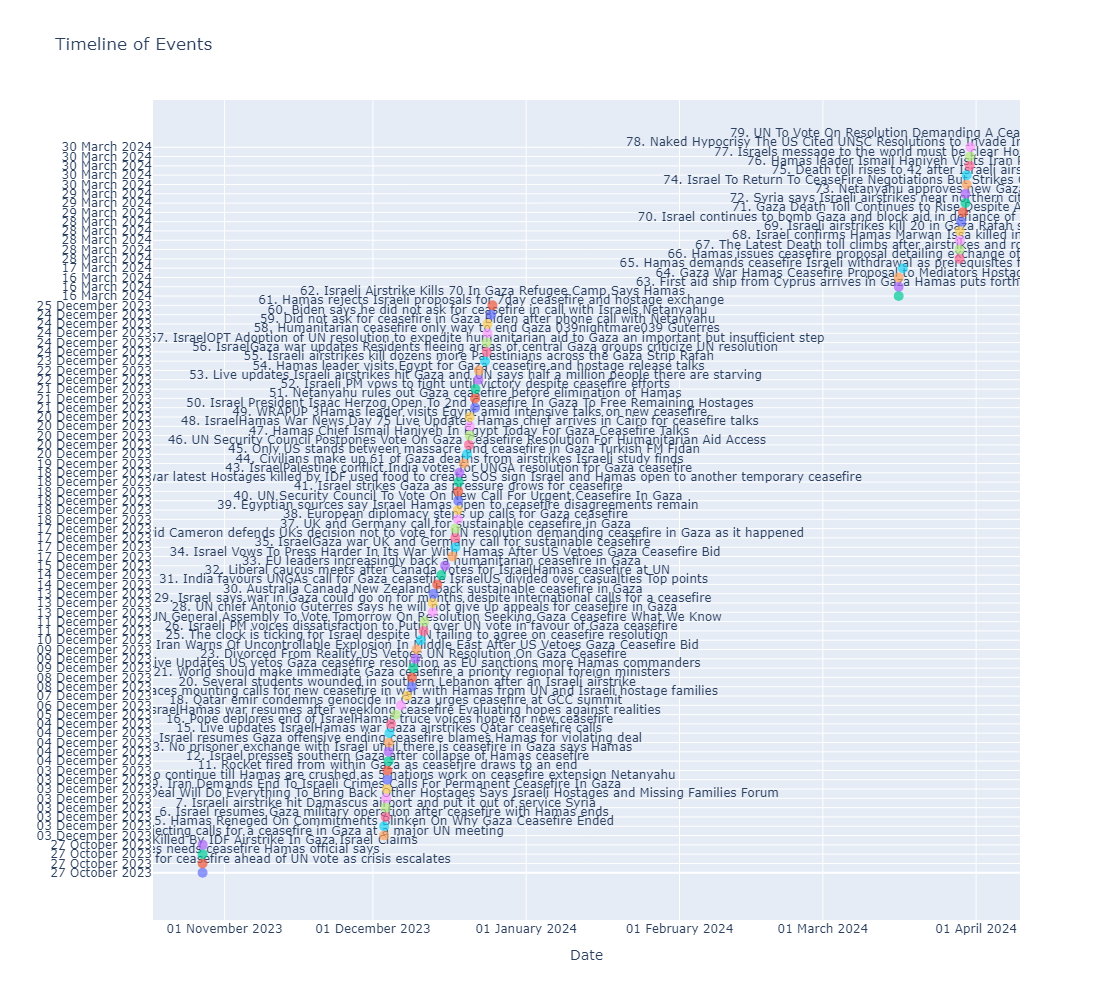

In [81]:
important_events_df['date'] = pd.to_datetime(important_events_df['date'])

# Sort events by date for better visualization
important_events_df = important_events_df.sort_values(by='date').reset_index(drop=True)

# Create a timeline plot using Plotly
fig = go.Figure()

# Define unique y positions for events to avoid overlap
y_positions = list(range(len(important_events_df)))

# Add a number sequence for events
for index, row in important_events_df.iterrows():
    event_text = f"{index + 1}. {row['title']}"
    fig.add_trace(go.Scatter(
        x=[row['date']],
        y=[y_positions[index]],  # Use unique y positions
        mode='markers+text',
        text=[event_text],
        textposition='top center',
        marker=dict(size=10, opacity=0.7),
        hoverinfo='text',
        name=row['title']
    ))

# Update layout
fig.update_layout(
    title='Timeline of Events',
    xaxis_title='Date',
    yaxis=dict(
        title='',
        tickvals=y_positions,
        ticktext=important_events_df['date'].dt.strftime('%d %B %Y').tolist(),
        showticklabels=True,
        automargin=True
    ),
    xaxis_tickformat='%d %B %Y',
    showlegend=False,
    height=1000,  # Adjust height to fit all events
    hovermode='closest'
)

# Show the Plotly timeline figure
fig.show()